<a href="https://colab.research.google.com/github/victoregomezf-maker/seminario/blob/main/Predicci%C3%B3n_de_demanda_insumos_medicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE DEMANDA DE INSUMOS MEDICOS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Configuración de gráficas
%matplotlib inline
sns.set_style("whitegrid")

# **FASE #1: LIMPIAR DATOS Y EDA - ANALISIS EXPLORATIRO DE DATOS**

# **LIMPIEZA Y PREPARACION DE LOS DATOS**

In [2]:
# Carga del archivo
ruta = "/content/DEMANDA AÑO 2025.csv"
df_raw = pd.read_csv(ruta, sep=';', header=None, encoding='latin-1')

# LISTA COMPLETA (Asegúrate de que NOVIEMBRE esté aquí)
lista_meses = ['FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO',
                'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE']

print(f"Archivo cargado. Meses a buscar: {len(lista_meses)}")

Archivo cargado. Meses a buscar: 10


In [3]:
resultados = []
i = 0

while i < len(df_raw):
    fila_texto = " ".join(df_raw.iloc[i].astype(str)).upper()

    # Buscamos el mes en la fila actual
    mes_encontrado = None
    for m in lista_meses:
        if m in fila_texto:
            mes_encontrado = m
            break

    if mes_encontrado:
        j = i + 1  # El primer producto está justo debajo del título
        while j < len(df_raw):
            fila_datos = df_raw.iloc[j].tolist()
            producto = str(fila_datos[0]).strip()

            # Si encontramos el espacio en blanco que pusiste, saltamos al siguiente mes
            if producto.lower() in ['nan', ''] or "PRODUCTO" in producto.upper():
                break

            # Extraemos los días (1 a 31)
            for dia in range(1, 32):
                if dia < len(fila_datos):
                    try:
                        valor = str(fila_datos[dia]).replace(',', '.').strip()
                        cantidad = float(valor) if valor.lower() not in ['nan', ''] else 0.0
                    except:
                        cantidad = 0.0

                    resultados.append({
                        "Producto": producto,
                        "Mes": mes_encontrado,
                        "Dia": dia,
                        "Cantidad": cantidad
                    })
            j += 1
        i = j
    else:
        i += 1

df_final = pd.DataFrame(resultados)
print(f"Meses detectados: {df_final['Mes'].unique()}")

Meses detectados: ['FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO' 'AGOSTO' 'SEPTIEMBRE'
 'OCTUBRE' 'NOVIEMBRE']


In [4]:
# 1. Crear número de mes (Enero=1 ... Noviembre=11)
mes_a_num = {m: i+1 for i, m in enumerate(lista_meses)}
df_final['Month_Num'] = df_final['Mes'].map(mes_a_num)

# 2. Crear ID de Producto
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['Producto_ID'] = le.fit_transform(df_final['Producto'])

# 3. Quitar días que no existen (Limpieza de calendario)
# Febrero máximo 28, meses de 30 días, etc.
meses_30 = [4, 6, 9, 11] # Abril, Junio, Septiembre, Noviembre
df_final = df_final[~((df_final['Month_Num'] == 2) & (df_final['Dia'] > 28))]
for m in meses_30:
    df_final = df_final[~((df_final['Month_Num'] == m) & (df_final['Dia'] > 30))]

print(f"Total de registros finales: {len(df_final):,}")
print(f"Rango de meses procesados: {df_final['Month_Num'].min()} a {df_final['Month_Num'].max()}")

Total de registros finales: 60,872
Rango de meses procesados: 1 a 10


# **VERIFICACION DE LOS DATOS**

In [5]:
# 1. Verificar meses únicos
meses_detectados = df_final['Mes'].unique()
print(f"--- REVISIÓN DE MESES ---")
print(f"Meses encontrados ({len(meses_detectados)}): {meses_detectados}")

# 2. Resumen por mes para ver si están completos
resumen = df_final.groupby('Mes').agg(
    Total_Productos=('Producto', 'nunique'),
    Suma_Total_Demanda=('Cantidad', 'sum')
).reset_index()

print("\n--- RESUMEN DE DATOS POR MES ---")
display(resumen)

if len(meses_detectados) >= 10:
    print("\n ¡Los 10 meses están presentes y la tabla está lista!")
else:
    print("\n ALERTA: No se detectaron todos los meses. Revisa los títulos del archivo.")

--- REVISIÓN DE MESES ---
Meses encontrados (10): ['FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO' 'AGOSTO' 'SEPTIEMBRE'
 'OCTUBRE' 'NOVIEMBRE']

--- RESUMEN DE DATOS POR MES ---


,Mes,Total_Productos,Suma_Total_Demanda
0,ABRIL,207,325347.0
1,AGOSTO,176,189158.0
2,FEBRERO,154,241681.0
3,JULIO,214,334733.0
4,JUNIO,202,407528.0
5,MARZO,174,291806.0
6,MAYO,181,392873.0
7,NOVIEMBRE,232,440611.0
8,OCTUBRE,209,366062.0
9,SEPTIEMBRE,248,383691.0



 ¡Los 10 meses están presentes y la tabla está lista!


# **PREPARACION DE LOS DATOS**

In [6]:
# BLOQUE 1: Preparación de columnas para Análisis de Inventario
import pandas as pd

# Aseguramos que los datos sean numéricos y los meses estén ordenados
df_final['Cantidad'] = pd.to_numeric(df_final['Cantidad'], errors='coerce').fillna(0)

# Agrupamos para ver el comportamiento histórico por producto
analisis_pedidos = df_final.groupby('Producto')['Cantidad'].agg(['sum', 'mean', 'max', 'std']).reset_index()
analisis_pedidos.columns = ['Producto', 'Total_Consumido', 'Promedio_Diario', 'Pico_Maximo', 'Variabilidad_STD']

print("✅ Base de análisis de inventario lista.")
display(analisis_pedidos.head(5))

✅ Base de análisis de inventario lista.


,Producto,Total_Consumido,Promedio_Diario,Pico_Maximo,Variabilidad_STD
0,00002M - MASCARA ORONASAL NIV TALLA M REF. MP0...,81.0,0.333333,5.0,0.574960
1,00003K - KIT PEDIATRIA 1 INCLUYE REF. C0R81 Y ...,8.0,0.137931,1.0,0.347839
2,00003M - MASCARA ORONASAL NIV TALLA L REF. MP0...,15.0,0.163043,5.0,0.616213
3,00011J - JERINGA TAG 150 SYR,17.0,0.566667,1.0,0.504007
4,00016E - EXTENSION PARA LINEAS DE OXIGENO PARA...,100.0,3.225806,6.0,2.092999


# **EDA - ANALISIS DE FRECUENCIA PARA EL ABASTESIMIENTO**

In [7]:
# BLOQUE: Simulación Comparativa de Pedidos
import pandas as pd
import numpy as np

# Tomamos un producto de alta rotación para el ejemplo
producto_ejemplo = df_final.groupby('Producto')['Cantidad'].sum().idxmax()
datos_sim = df_final[df_final['Producto'] == producto_ejemplo].copy()

# Parámetros
dias_simulados = len(datos_sim)
consumo_diario_prom = datos_sim['Cantidad'].mean()

# ESCENARIO A: Pedido cada 2 días (Frecuente)
pedidos_2d = dias_simulados / 2
stock_seguridad_2d = datos_sim['Cantidad'].max() * 0.5 # Menos stock porque pides seguido

# ESCENARIO B: Pedido cada 15 días (Optimizado)
pedidos_15d = dias_simulados / 15
stock_seguridad_15d = datos_sim['Cantidad'].max() * 1.2 # Más stock para aguantar la quincena

comparativa = pd.DataFrame({
    'Frecuencia': ['Cada 2 días', 'Cada 15 días'],
    'Número de Pedidos (al mes)': [15, 2],
    'Carga Administrativa': ['MUY ALTA', 'BAJA'],
    'Riesgo de Ruptura': ['Bajo', 'Controlado (con Stock)'],
    'Inventario Sugerido': [consumo_diario_prom * 2 + stock_seguridad_2d,
                            consumo_diario_prom * 15 + stock_seguridad_15d]
})

print(f"Análisis para el producto: {producto_ejemplo}")
display(comparativa)

Análisis para el producto: STICKER ESCUDO COLOR ROJO DELINEADO BLANCO 3CMS ADHESIVO TEXTIL.


,Frecuencia,Número de Pedidos (al mes),Carga Administrativa,Riesgo de Ruptura,Inventario Sugerido
0,Cada 2 días,15,MUY ALTA,Bajo,7712.926540
1,Cada 15 días,2,BAJA,Controlado (con Stock),39188.599052


In [8]:
# BLOQUE 1: Cálculo General de Eficiencia
resumen_general = df_final.groupby('Producto')['Cantidad'].agg(['mean', 'max', 'std']).reset_index()

# Calculamos cuánto inventario promedio tendrías que cargar
resumen_general['Inventario_15_dias'] = (resumen_general['mean'] * 15) + (resumen_general['std'] * 2)
resumen_general['Inventario_2_dias'] = (resumen_general['mean'] * 2) + (resumen_general['std'] * 2)

# Costo administrativo (simulado: cada pedido cuesta tiempo/dinero)
pedidos_año_15d = 24  # 2 al mes
pedidos_año_2d = 180  # 15 al mes

print("Simulación general completada para todos los productos.")

Simulación general completada para todos los productos.


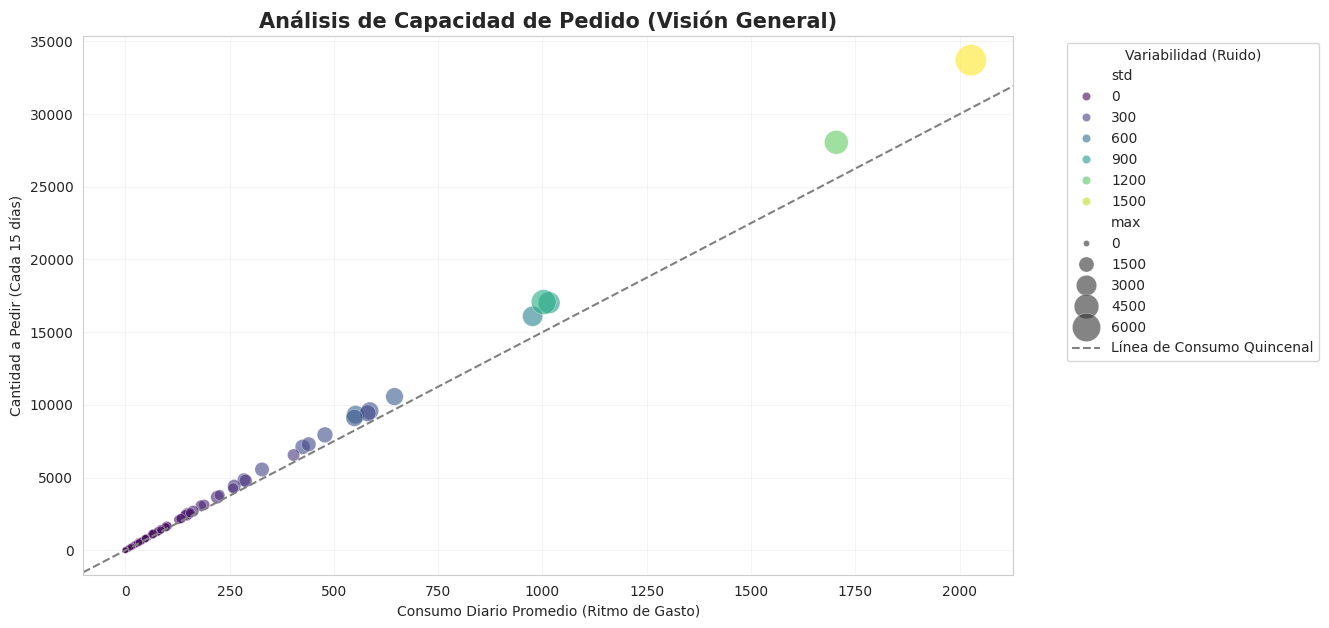

In [9]:
# BLOQUE 2: Gráfico de Eficiencia General
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

# Graficamos la relación entre el promedio de consumo y el inventario necesario
sns.scatterplot(data=resumen_general, x='mean', y='Inventario_15_dias',
                size='max', hue='std', palette='viridis', sizes=(20, 500), alpha=0.6)

plt.axline((0, 0), slope=15, color='gray', linestyle='--', label='Línea de Consumo Quincenal')

plt.title('Análisis de Capacidad de Pedido (Visión General)', fontsize=15, fontweight='bold')
plt.xlabel('Consumo Diario Promedio (Ritmo de Gasto)')
plt.ylabel('Cantidad a Pedir (Cada 15 días)')
plt.legend(title='Variabilidad (Ruido)', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.2)
plt.show()

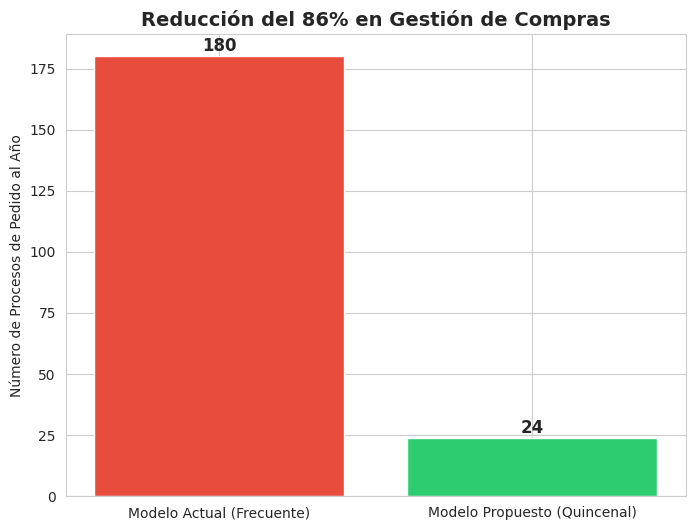

In [10]:
# BLOQUE 3: Gráfico de Carga Administrativa
labels = ['Modelo Actual (Frecuente)', 'Modelo Propuesto (Quincenal)']
pedidos = [180, 24] # Pedidos por año aproximadamente

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, pedidos, color=['#e74c3c', '#2ecc71'])

# Añadir el número encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, yval, ha='center', fontsize=12, fontweight='bold')

plt.title('Reducción del 86% en Gestión de Compras', fontsize=14, fontweight='bold')
plt.ylabel('Número de Procesos de Pedido al Año')
plt.show()

**EDA - HISTOGRAMA DE DISTRIBUCION DE DEMANDA**

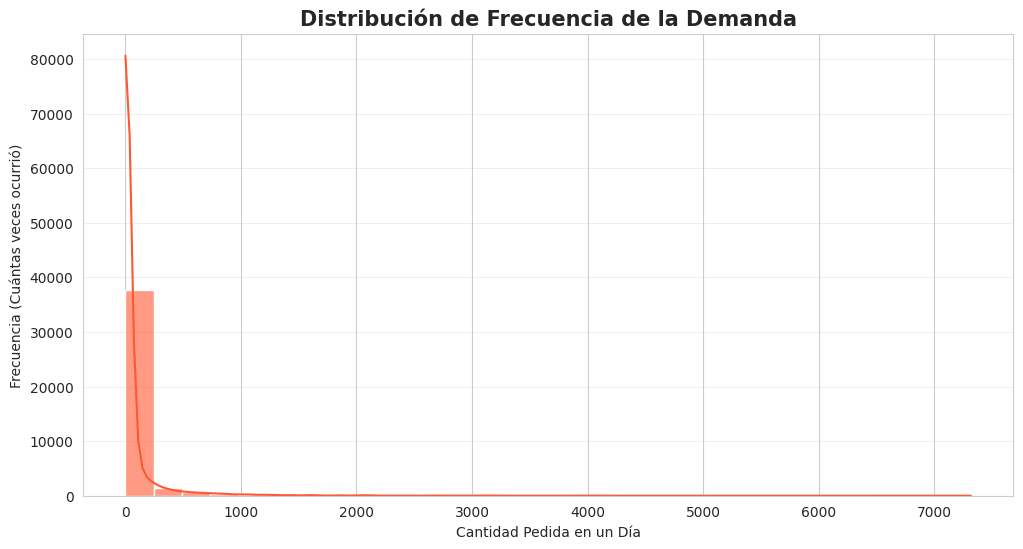

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Filtramos cantidades mayores a 0 para ver la demanda real
sns.histplot(df_final[df_final['Cantidad'] > 0]['Cantidad'],
             kde=True, color="#FF5733", bins=30, alpha=0.6)

plt.title('Distribución de Frecuencia de la Demanda', fontsize=15, fontweight='bold')
plt.xlabel('Cantidad Pedida en un Día')
plt.ylabel('Frecuencia (Cuántas veces ocurrió)')
plt.grid(axis='y', alpha=0.3)
plt.show()

**EDA - ANALISIS DE ESTACIONALIDAD MENSUAL**

/tmp/ipython-input-2555407688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estacionalidad_grafico, x='Mes', y='Cantidad', palette='magma')


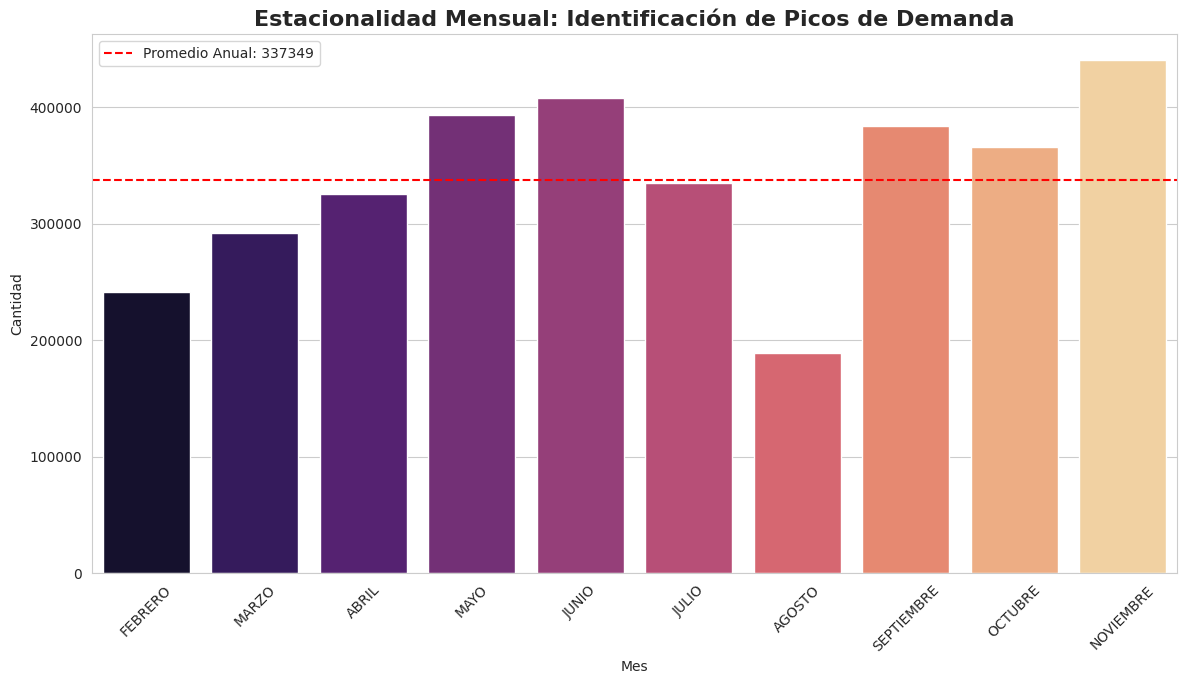

In [12]:
# Preparamos los datos
estacionalidad_grafico = df_final.groupby(['Month_Num', 'Mes'])['Cantidad'].sum().reset_index()

plt.figure(figsize=(14, 7))
# Usamos la paleta 'Spectral' o 'coolwarm' para que sea muy visual
sns.barplot(data=estacionalidad_grafico, x='Mes', y='Cantidad', palette='magma')

# Añadimos una línea de promedio anual para comparar
promedio_anual = estacionalidad_grafico['Cantidad'].mean()
plt.axhline(promedio_anual, color='red', linestyle='--', label=f'Promedio Anual: {int(promedio_anual)}')

plt.title('Estacionalidad Mensual: Identificación de Picos de Demanda', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**EDA - TOP 5 POR MES**

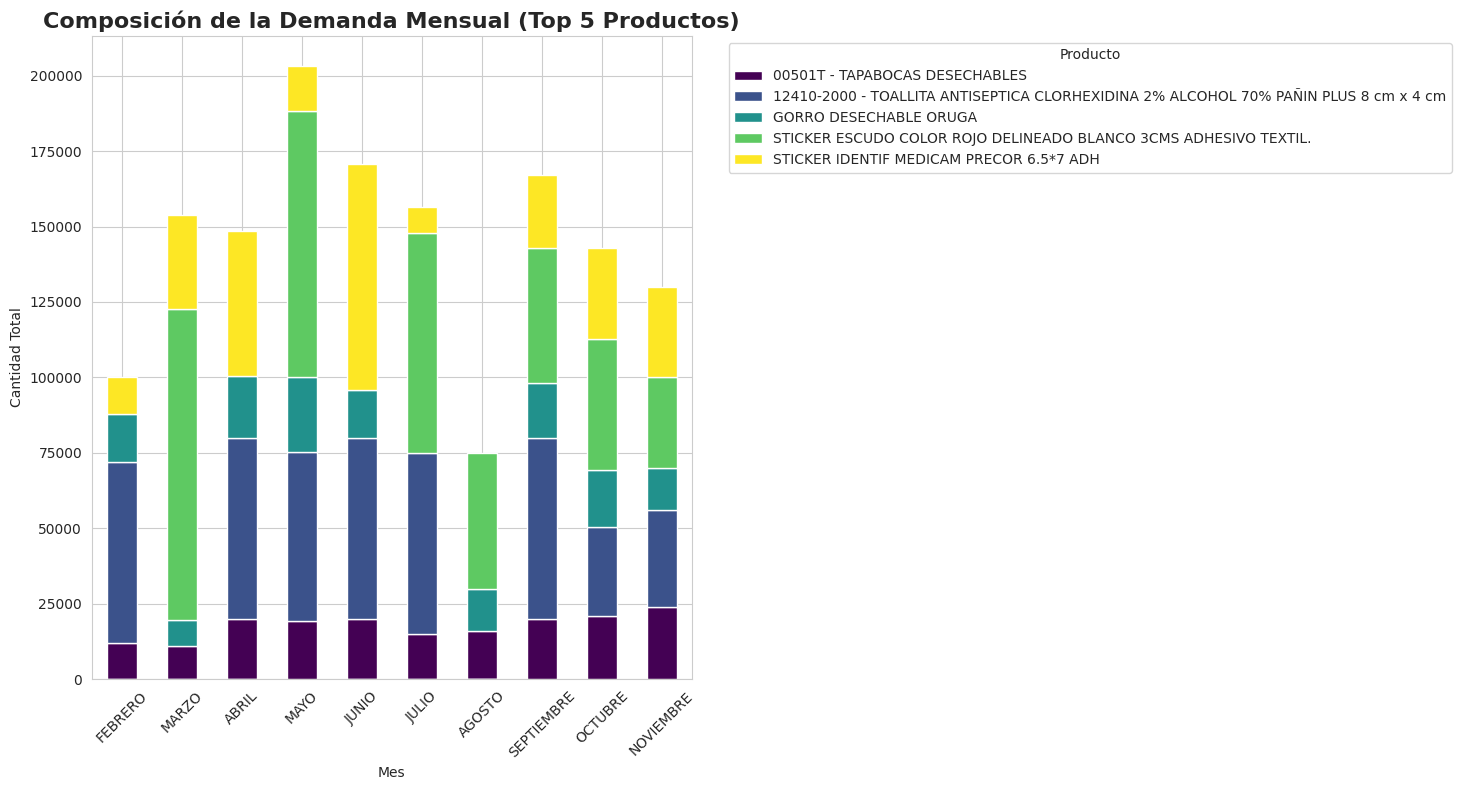

In [13]:
# Obtenemos los 5 productos más importantes
top_5_nombres = df_final.groupby('Producto')['Cantidad'].sum().nlargest(5).index
df_top_5 = df_final[df_final['Producto'].isin(top_5_nombres)]

# Creamos la tabla pivote para el gráfico apilado
pivot_top = df_top_5.pivot_table(index='Mes', columns='Producto', values='Cantidad', aggfunc='sum')
# Ordenamos los meses cronológicamente
pivot_top = pivot_top.reindex(lista_meses)

pivot_top.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')

plt.title('Composición de la Demanda Mensual (Top 5 Productos)', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad Total')
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**PREPARACION DE DATOS PARA MODELO DE REGRESION LINEAL**

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Codificamos el nombre del producto a un ID numérico
le = LabelEncoder()
df_final['Producto_ID'] = le.fit_transform(df_final['Producto'])

# 2. Definimos nuestras variables de entrada (X) y lo que queremos predecir (y)
# Usamos Mes, Día y el ID del Producto como tus referencias
X = df_final[['Month_Num', 'Dia', 'Producto_ID']]
y = df_final['Cantidad']

# 3. Dividimos los datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"✅ Datos preparados: {len(X_train)} filas para entrenamiento.")

✅ Datos preparados: 42610 filas para entrenamiento.


# **FASE #2: MODELO BASE - REGRESION LINEAL**

In [15]:
# Inicializamos y entrenamos el modelo
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

# Realizamos las predicciones con los datos de prueba
y_pred = modelo_lr.predict(X_test)

# Calculamos métricas de precisión
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

📊 Métricas del Modelo:
- Error Cuadrático Medio (MSE): 77262.27
- Precisión (R2 Score): 0.0006


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Calculamos las métricas adicionales
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raíz del error cuadrático
r2 = r2_score(y_test, y_pred)

print("EVALUACIÓN COMPLETA DE REGRESIÓN LINEAL")
print("-" * 40)
print(f" R² Score (Precisión): {r2:.4f}")
print(f" MAE (Error promedio en unidades): {mae:.2f}")
print(f" RMSE (Desviación estándar del error): {rmse:.2f}")
print(f" MSE (Error cuadrático): {mse:.2f}")
print("-" * 40)

📌 EVALUACIÓN COMPLETA DE REGRESIÓN LINEAL
----------------------------------------
 R² Score (Precisión): 0.0006
 MAE (Error promedio en unidades): 88.18
 RMSE (Desviación estándar del error): 277.96
 MSE (Error cuadrático): 77262.27
----------------------------------------


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Calculamos las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 2. Creamos el DataFrame
metricas_data = {
    'Métrica': ['R² (Precisión)', 'MAE (Error Medio)', 'RMSE', 'MSE'],
    'Valor': [r2, mae, rmse, mse],
    'Estado': ['Evaluando', 'Evaluando', 'Evaluando', 'Evaluando']
}

df_metricas = pd.DataFrame(metricas_data)

# 3. Aplicamos el truco de estilo (Colores según el nivel de error)
def resaltar_metricas(s):
    # Si el R2 es menor a 0.3 o el MAE es alto, ponemos fondo rojo suave
    if s.Métrica == 'R² (Precisión)' and s.Valor < 0.3:
        return ['background-color: #ffcccc'] * len(s)
    if s.Métrica == 'MAE (Error Medio)' and s.Valor > 5: # Ajusta el 5 según tu volumen
        return ['background-color: #fff3cd'] * len(s) # Amarillo advertencia
    return [''] * len(s)

# Mostramos la tabla con estilo
print("TABLA DE DESEMPEÑO DE REGRESIÓN LINEAL")
df_metricas.style.apply(resaltar_metricas, axis=1).format({'Valor': "{:.4f}"})

📊 TABLA DE DESEMPEÑO DE REGRESIÓN LINEAL


,Métrica,Valor,Estado
0,R² (Precisión),0.0006,Evaluando
1,MAE (Error Medio),88.1844,Evaluando
2,RMSE,277.9609,Evaluando
3,MSE,77262.2650,Evaluando


**GRAFICO VALORES REALES VS PREDICCIONES**

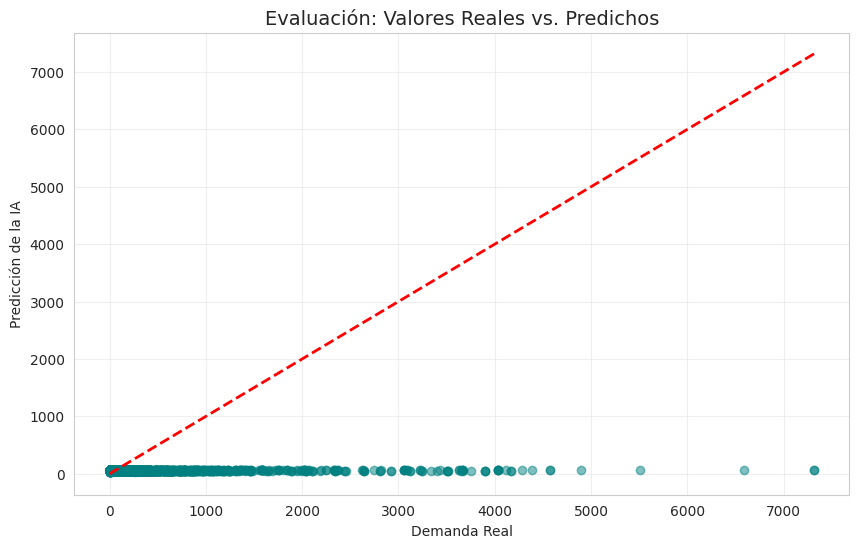

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Evaluación: Valores Reales vs. Predichos', fontsize=14)
plt.xlabel('Demanda Real')
plt.ylabel('Predicción de la IA')
plt.grid(True, alpha=0.3)
plt.show()

**GRAFICO DE DISTRIBUCION DE ERROR**

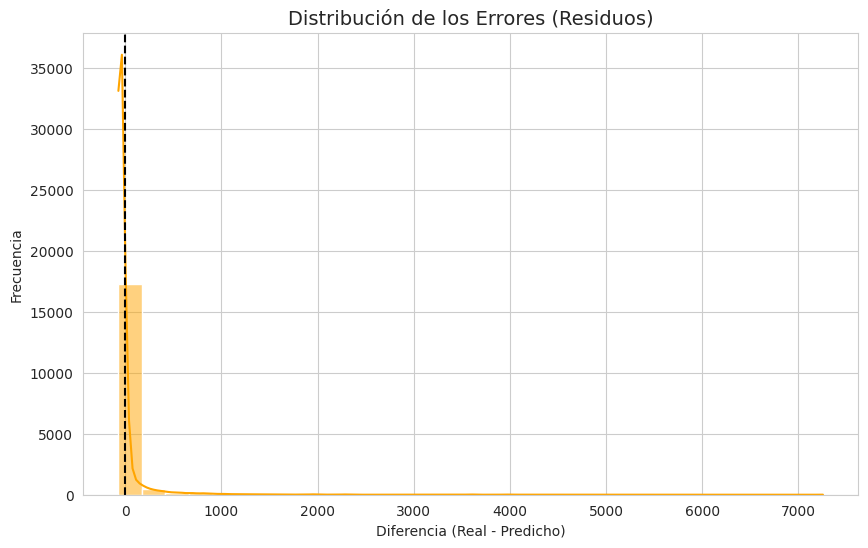

In [17]:
plt.figure(figsize=(10, 6))
error = y_test - y_pred
sns.histplot(error, kde=True, color='orange', bins=30)

plt.title('Distribución de los Errores (Residuos)', fontsize=14)
plt.xlabel('Diferencia (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

# **FASE #3: MODELO COMPLEJO Random Forest**

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Definimos el modelo
# n_estimators=100 significa que usaremos 100 árboles para decidir el resultado
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamos con los mismos datos X_train y y_train que usamos en la Regresión
modelo_rf.fit(X_train, y_train)

# Realizamos las predicciones
y_pred_rf = modelo_rf.predict(X_test)

print("Modelo Random Forest entrenado con éxito.")

Modelo Random Forest entrenado con éxito.


**METRICAS**

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Calculamos todas las métricas para Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 2. Creamos la tabla comparativa
metricas_rf_data = {
    'Métrica': ['R² (Precisión)', 'MAE (Error Medio)', 'RMSE', 'MSE'],
    'Valor': [r2_rf, mae_rf, rmse_rf, mse_rf],
    'Modelo': ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest']
}

df_metricas_rf = pd.DataFrame(metricas_rf_data)

# 3. Función de estilo (Verde para éxito)
def estilo_exito(s):
    return ['background-color: #d4edda; color: #155724'] * len(s)

print("TABLA DE DESEMPEÑO: RANDOM FOREST")
# Mostramos la tabla formateada
display(df_metricas_rf.style.apply(estilo_exito, axis=1).format({'Valor': "{:.4f}"}))

TABLA DE DESEMPEÑO: RANDOM FOREST


,Métrica,Valor,Modelo
0,R² (Precisión),0.6109,Random Forest
1,MAE (Error Medio),36.3508,Random Forest
2,RMSE,173.4332,Random Forest
3,MSE,30079.0607,Random Forest


**GRAFICO REAL VS PREDICHO**

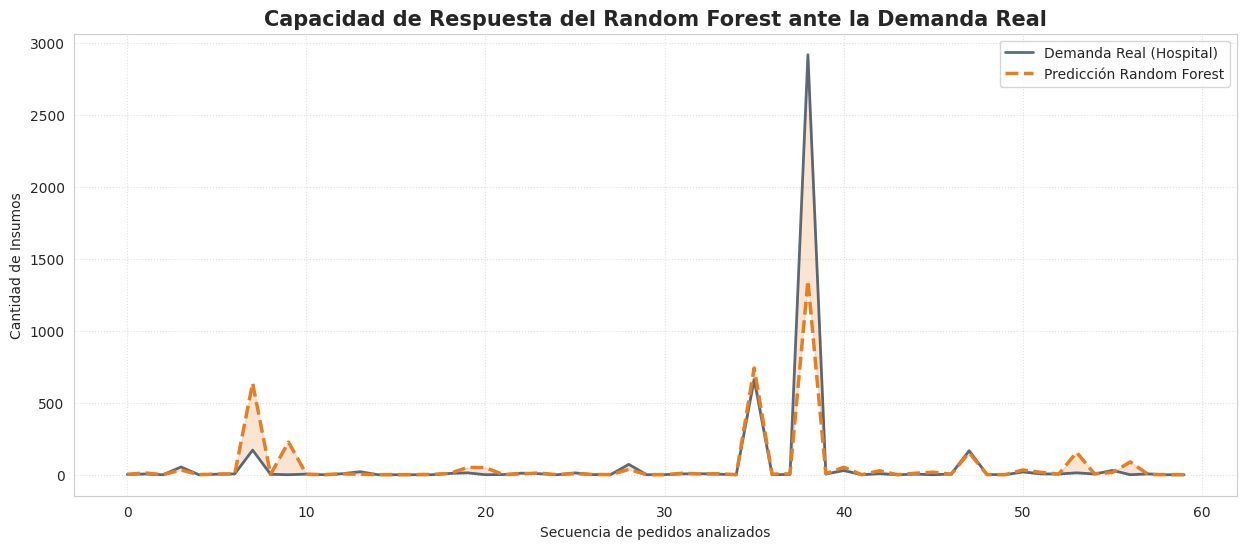

In [28]:
import matplotlib.pyplot as plt

# Creamos un gráfico de líneas para ver el comportamiento
plt.figure(figsize=(15, 6))

# Graficamos una muestra de 60 datos para que sea legible
plt.plot(y_test.values[:60], label='Demanda Real (Hospital)', color='#34495e', linewidth=2, alpha=0.8)
plt.plot(y_pred_rf[:60], label='Predicción Random Forest', color='#e67e22', linestyle='--', linewidth=2.5)

# Sombreado para resaltar la diferencia (Error)
plt.fill_between(range(60), y_test.values[:60], y_pred_rf[:60], color='#e67e22', alpha=0.2)

plt.title('Capacidad de Respuesta del Random Forest ante la Demanda Real', fontsize=15, fontweight='bold')
plt.xlabel('Secuencia de pedidos analizados')
plt.ylabel('Cantidad de Insumos')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

**GRAFICO DE DIFERENCIA DE ERROR**

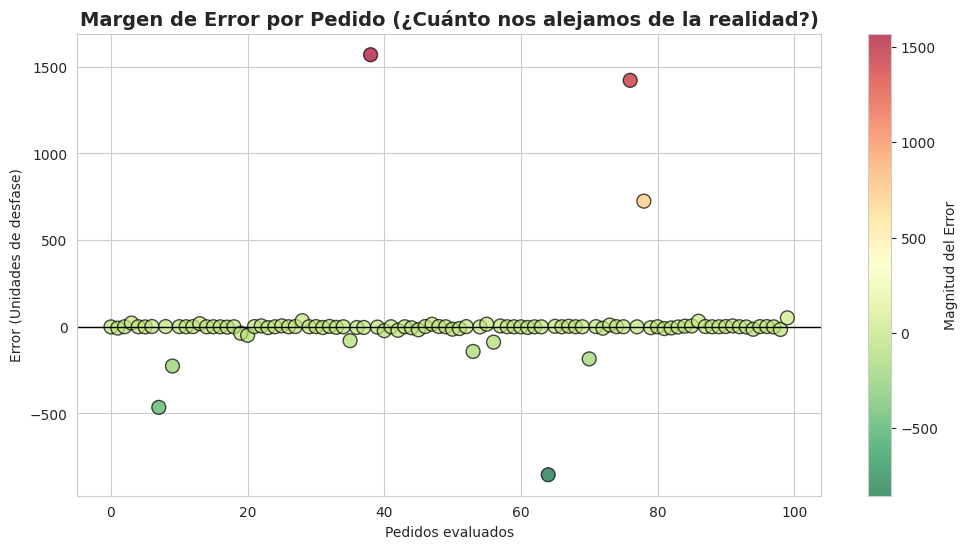

In [27]:
# Calculamos la diferencia diaria
error_diario = y_test.values - y_pred_rf

plt.figure(figsize=(12, 6))
plt.scatter(range(len(error_diario[:100])), error_diario[:100], c=error_diario[:100], cmap='RdYlGn_r', s=100, edgecolors='black', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Margen de Error por Pedido (¿Cuánto nos alejamos de la realidad?)', fontsize=14, fontweight='bold')
plt.xlabel('Pedidos evaluados')
plt.ylabel('Error (Unidades de desfase)')
plt.colorbar(label='Magnitud del Error')
plt.show()